In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  # Import StandardScaler
from numpy.polynomial.polynomial import Polynomial
import warnings
warnings.filterwarnings('ignore')

In [39]:
GROUPS_NAMES = ["E", "N"]
BOOL_GROUPS_NAMES = [0,1]
METRICS=13
target_subjects = [1,19, 23,7, 24, 26, 10, 13, 16, 17, 20, 27]
selected_subjects = [1,19, 23,7, 24, 26, 10, 16, 17, 20]
#metrics_tw = np.empty((8*(len(target_subjects)-2), METRICS)) #remove 2 subjects with nan
#metrics_nh = np.empty((8*(len(target_subjects)-2), METRICS))
metrics_tw = np.empty((8*len(selected_subjects), METRICS)) #remove 2 subjects with nan
metrics_nh = np.empty((8*len(selected_subjects), METRICS))

In [6]:
def determine_expertise(score, bool =False):
    if (score < 4): 
        if bool:
            return BOOL_GROUPS_NAMES[0] #expert
        else: 
            return GROUPS_NAMES[0] #expert
    else : 
        if bool:
            return BOOL_GROUPS_NAMES[1]
        else:
            return GROUPS_NAMES[1] #non expert

def get_expertise(subject):
    subjects_info = np.load("subject_info_modified.npy")
    for row in subjects_info:
        if row[0] == subject:
            score = row[-1]
            return score

In [40]:
subject_number = 0
for subject in selected_subjects:
    data = np.load(f"Features/S_{subject}/ot_metrics.npy")

    metrics_tw[subject_number*8:(subject_number+1)*8, :] = data[:, :, 0]
    metrics_nh[subject_number*8:(subject_number+1)*8, :] = data[:, :, 1]

    subject_number = subject_number + 1

In [7]:
def expertise_array(selected_subjects):
    expertise = np.zeros(8*len(selected_subjects), dtype=int)
    for i in range (len(selected_subjects)):
        n = i*8
        m = (i+1)*8
        subject = selected_subjects[i]
        score = get_expertise(subject)
        level = determine_expertise(score, bool =True)
        expertise[n:m]=level
    return expertise #same dimension as metrics but with 0 when expert and 1 when novice

In [8]:
def cluster_data(data, number_of_cluster, target_subjects):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    kmeans = KMeans(n_clusters=number_of_cluster, random_state=0).fit(data_scaled)
    #print("Cluster Centers:", kmeans.cluster_centers_)
    #print("Labels:", kmeans.labels_)
    pca = PCA(n_components=4)

    reduced_data = pca.fit_transform(data_scaled)
    print(np.cumsum(pca.explained_variance_ratio_))

    markers = ['o', 'x']  # circles for 'e' (expert) and crosses for 'n' (non-expert)

    plt.figure(figsize=(10, 6))
    colors = ['green', 'blue']
    markers = ['o', 'x']  # circles for 'e' (expert) and crosses for 'n' (non-expert)

    expertise = expertise_array(target_subjects)
    
    for i in range(number_of_cluster):
            cluster_data = reduced_data[kmeans.labels_ == i]
            expertise_selected = expertise[kmeans.labels_ == i]
            
            for j, (data_point, exp) in enumerate(zip(cluster_data, expertise_selected)):
                marker = 'o' if exp == 0 else 'x'  # Circles for 'e' (expert), crosses for 'n' (non-expert)
                #label = 'Experts' if exp == 'e' else 'Novices'
                plt.scatter(data_point[0], data_point[1], color=colors[i], marker=marker, alpha=0.5, s=50, label=f'Cluster {i+1}' if j == 0 else None)
        
    centers = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers[:, 0], centers[:, 1], marker='X', s=200, color='black', label='Centers')
        
    plt.title('Cluster visualization with PCA-reduced data (2D)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [136]:
test = np.array([0,1])
test[1] = 3
test

array([0, 3])

In [140]:
def cluster_data(data, number_of_cluster, target_subjects, tool):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    kmeans = KMeans(n_clusters=number_of_cluster, random_state=0).fit(data_scaled)
    
    pca = PCA(n_components=2)  
    reduced_data = pca.fit_transform(data_scaled)
    print(np.cumsum(pca.explained_variance_ratio_))
    
    plt.figure(figsize=(10, 6))
    colors = ['green', 'blue']
    markers = ['o', 'x']  # Circles for 'e' (expert), crosses for 'n' (novice)
    
    expertise = expertise_array(target_subjects)  # Supposons que vous avez une fonction expertise_array qui retourne le niveau d'expertise

    number_expert =np.array([0,0])
    number_novice = np.array([0,0])
    for i in range(number_of_cluster):
        cluster_data = reduced_data[kmeans.labels_ == i]
        print(reduced_data.shape)
        expertise_selected = expertise[kmeans.labels_ == i]
        
        for j, (data_point, exp) in enumerate(zip(cluster_data, expertise_selected)):
            marker = markers[0] if exp == 0 else markers[1]
            label = 'Experts' if exp == 0 else 'Novices'
            plt.scatter(data_point[0], data_point[1], color=colors[i], marker=marker, alpha=0.5, s=50, label=f'Cluster {i+1} - {label}' if j == 0 else None)
        number_expert[i] = np.sum(expertise_selected)
        number_novice[i] = len(expertise_selected)-number_expert[i]
        print(f'Number of novice in cluster {i} is {number_novice[i]} and the number of experts is {number_expert[i]}')
        print(f'Percentage of novice in cluster {i} is {np.round(number_novice[i]/len(expertise_selected)*100,2)} and the number of experts is {np.round(number_expert[i]/len(expertise_selected)*100,2)}')
        
    

    if (number_expert[1]/len(expertise_selected))>0.5: #we are in the novice cluster
        print('---------------------------------------------')
        print(f'Percentage of true label is {np.round((number_expert[1]+number_novice[0])/len(expertise)*100,2)}')
        print('---------------------------------------------')
    else:  #we are in the expert cluster
        print('---------------------------------------------')
        print(f'Percentage of true label is {np.round((number_expert[0]+number_novice[1])/len(expertise)*100,2)}')
        print('---------------------------------------------')
    

    centers = pca.transform(kmeans.cluster_centers_)
    for i, (center, color) in enumerate(zip(centers, colors)):
        plt.scatter(center[0], center[1], marker='X', s=200, color=color, label=f'Cluster {i+1} - Center')
    

    plt.title(f'{tool} - Cluster visualization with PCA-reduced data (2D)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()


[0.27061435 0.48915658]
(80, 2)
Number of novice in cluster 0 is 27 and the number of experts is 8
Percentage of novice in cluster 0 is 77.14 and the number of experts is 22.86
(80, 2)
Number of novice in cluster 1 is 13 and the number of experts is 32
Percentage of novice in cluster 1 is 28.89 and the number of experts is 71.11
---------------------------------------------
Percentage of true label is 73.75
---------------------------------------------


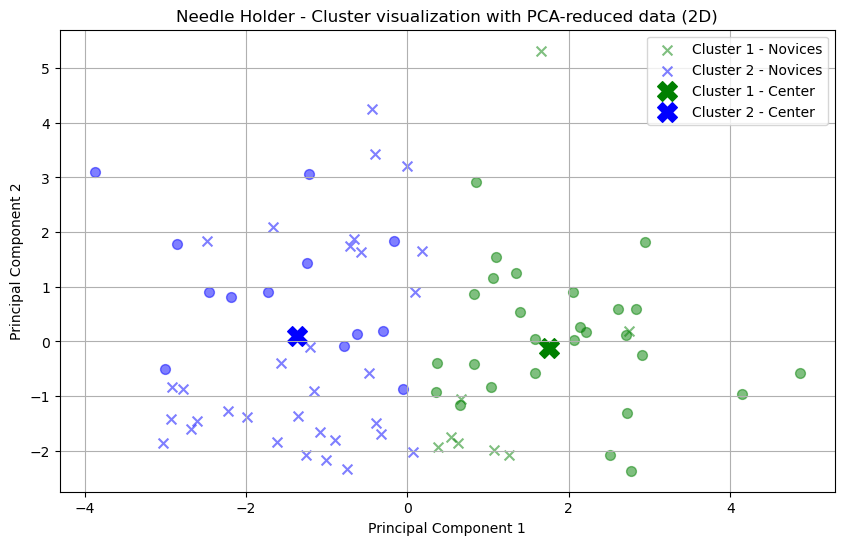

In [141]:
cluster_data(metrics_nh, 2, selected_subjects, tool='Needle Holder')

[0.28132324 0.47811912]
(80, 2)
Number of novice in cluster 0 is 11 and the number of experts is 28
Percentage of novice in cluster 0 is 28.21 and the number of experts is 71.79
(80, 2)
Number of novice in cluster 1 is 29 and the number of experts is 12
Percentage of novice in cluster 1 is 70.73 and the number of experts is 29.27
---------------------------------------------
Percentage of true label is 71.25
---------------------------------------------


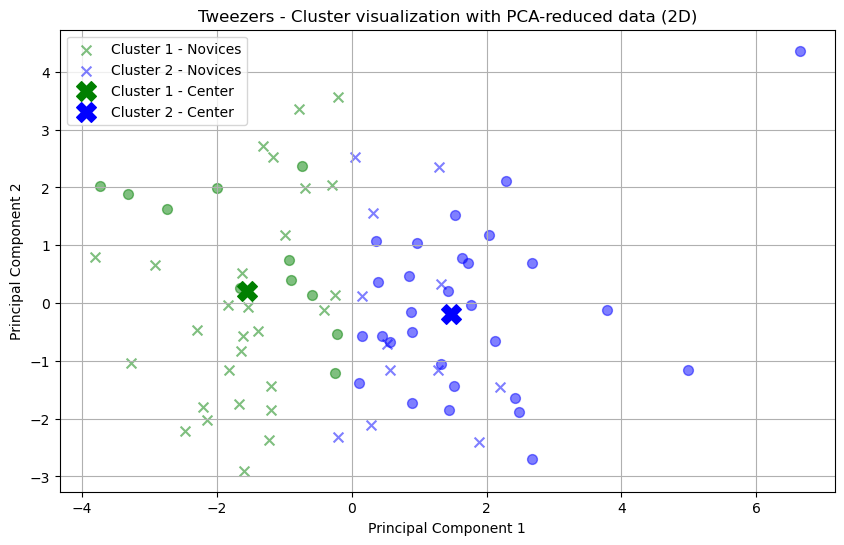

In [142]:
cluster_data(metrics_tw, 2, selected_subjects, tool='Tweezers')

Only keeping significant metrics

In [122]:
METRICS_NH=7
METRICS_TW= 5
BOOL_GROUPS_NAMES = [0,1]
target_subjects = [1,19, 23,7, 24, 26, 10, 13, 16, 17, 20, 27]
#metrics_tw = np.empty((8*(len(target_subjects)-2), METRICS)) #remove 2 subjects with nan
#metrics_nh = np.empty((8*(len(target_subjects)-2), METRICS))
metrics_nh_selected_ = np.zeros((8*len(target_subjects), METRICS_NH)) #remove 2 subjects with nan
metrics_tw_selected_ = np.zeros((8*len(target_subjects), METRICS_TW))

In [123]:
def select_significant_metrics(pos_to_del, array):
    data_selected = array.copy()
    for idx in sorted(pos_to_del, reverse=True):  # Remove columns in the decreasing order
        data_selected = np.delete(data_selected, idx, axis=1)
    return data_selected

In [124]:
subject_number = 0
for subject in target_subjects:
    data = np.load(f"Features/S_{subject}/ot_metrics.npy")
    data_nh = data[:, :, 1]
    data_tw = data[:, :, 0]
    col_to_del_nh = [7,8,9,10,11,12]
    col_to_del_tw = [4,5,7,8,9,10,11,12]

    data_selected_nh = select_significant_metrics(col_to_del_nh, data_nh)
    data_selected_tw = select_significant_metrics(col_to_del_tw, data_tw)

    metrics_tw_selected_[subject_number*8:(subject_number+1)*8, :] = data_selected_tw
    metrics_nh_selected_[subject_number*8:(subject_number+1)*8, :] = data_selected_nh

    subject_number = subject_number + 1

[0.49616818 0.78114365]
(96, 2)
Number of novice in cluster 0 is 36 and the number of experts is 12
Percentage of novice in cluster 0 is 75.0 and the number of experts is 25.0
(96, 2)
Number of novice in cluster 1 is 12 and the number of experts is 36
Percentage of novice in cluster 1 is 25.0 and the number of experts is 75.0
---------------------------------------------
Percentage of true label is 75.0
---------------------------------------------


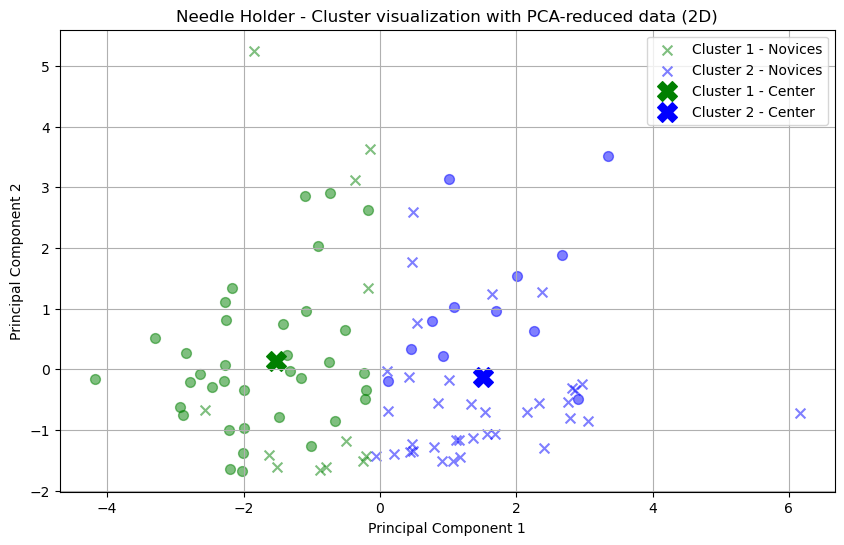

In [143]:
cluster_data(metrics_nh_selected_, 2, target_subjects, tool='Needle Holder')

[0.67949083 0.82014564]
(96, 2)
Number of novice in cluster 0 is 8 and the number of experts is 30
Percentage of novice in cluster 0 is 21.05 and the number of experts is 78.95
(96, 2)
Number of novice in cluster 1 is 40 and the number of experts is 18
Percentage of novice in cluster 1 is 68.97 and the number of experts is 31.03
---------------------------------------------
Percentage of true label is 72.92
---------------------------------------------


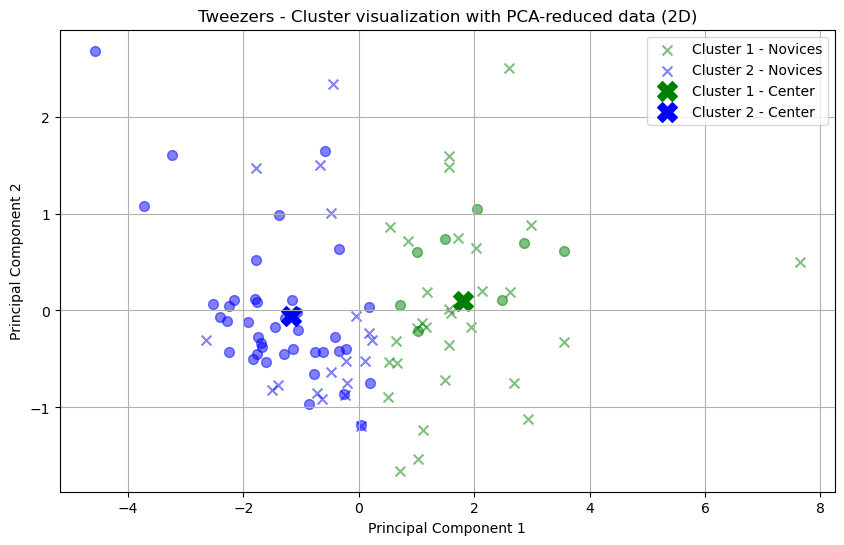

In [144]:
cluster_data(metrics_tw_selected_, 2, target_subjects, tool = 'Tweezers')